# Corrélations non linéaires

Les corrélations indiquent si deux variables sont linéairement équivalentes. Comment étendre cette notion à des variables liées mais pas de façon linéaire.

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [ ]:
%matplotlib inline

## Un exemple

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
Y = iris.target
import pandas
df = pandas.DataFrame(X)
df.columns = ["X1", "X2", "X3", "X4"]
df.head()

,X1,X2,X3,X4
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


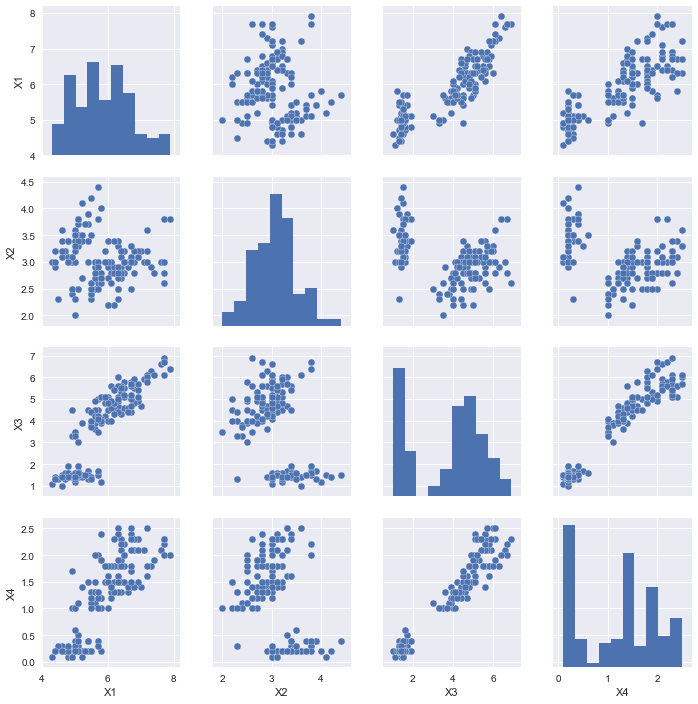

In [ ]:
import seaborn as sns
sns.set()
sns.pairplot(df)

Et les corrélations :

In [ ]:
df.corr()

,X1,X2,X3,X4
X1,1.000000,-0.109369,0.871754,0.817954
X2,-0.109369,1.000000,-0.420516,-0.356544
X3,0.871754,-0.420516,1.000000,0.962757
X4,0.817954,-0.356544,0.962757,1.000000


## Un peu de théorie

Le coefficient de [corrélation](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)) de Pearson est calculé comme suit :

$$cor(X_i, X_j) = \frac{cov(X_i, Y_i)}{\sigma(X_i)\sigma(X_j)}$$

Lorsque les variables sont centrées $\mathbb{E}X_i=\mathbb{E}X_j=0$, cette formule devient :

$$cor(X_i, X_j) = \frac{\mathbb{E}(X_i X_j)}{\sqrt{\mathbb{E}X_i^2 \mathbb{E}X_j^2}}$$

Lorsque les variables sont réduites $\mathbb{E}X_i^2=\mathbb{E}X_j^2=1$, cette formule devient $cor(X_i, X_j) = \mathbb{E}(X_i X_j)$. Admettons maintenant que l'on cherche à trouvé le coefficient $\alpha_{ij}$ qui minimise la variance du bruit $\epsilon_{ij}$ :

$$X_j = \alpha_{ij}X_i + \epsilon_{ij}$$

Le coefficient $\alpha_{ij}$ est le résultat d'une régression linéaire qui minimise $\mathbb{E}(X_j - \alpha_{ij}X_i)^2$. Si les variables $X_i$, $X_j$ sont centrées et réduites : $\alpha_{ij}^* = \mathbb{E}(X_i X_j) = cor(X_i, X_j)$. On étend cette définition dans le cas d'une fonction paramétrable $f$ : $f(\omega, X) \rightarrow \mathbb{R}$ et d'une régression non linéaire. On suppose que les paramètres $\omega^*$ minimise la quantité $\min_\omega (X_j  - f(\omega, X_i))^2$. On écrit alors $X_j = \alpha_{ij} \frac{f(\omega^*, X_i)}{\alpha_{ij}} + \epsilon_{ij}$ et on choisit $\alpha_{ij}$ de telle sorte que $\mathbb{E}\left(\frac{f(\omega^*, X_i)^2}{\alpha_{ij}^2}\right) = 1$. On définit la corrélation non linéaire au sens de $f$ : 

$$cor^f(X_i, X_j) = \sqrt{ \mathbb{E} (f(\omega, X_i)^2 )}$$

On vérifie que ce coefficient est compris entre [0, 1]. Cela signifie que cette définition interdit les corrélations négatives.

## Vérifications

Tout d'abord le cas linéaire :

In [ ]:
from sklearn.preprocessing import scale
import numpy

def correlation_etendue(df, model, **params):
    cor = df.corr()
    df = scale(df)    
    for i in range(cor.shape[0]):
        xi = df[:, i:i+1]
        for j in range(cor.shape[1]):
            mod = model(**params)
            xj = df[:, j]
            mod.fit(xi, xj)
            v = mod.predict(xi)
            c = numpy.std(v)
            cor.iloc[i,j] = c
    return cor

from sklearn.linear_model import LinearRegression
cor = correlation_etendue(df, LinearRegression, fit_intercept=False)
cor

,X1,X2,X3,X4
X1,1.000000,0.109369,0.871754,0.817954
X2,0.109369,1.000000,0.420516,0.356544
X3,0.871754,0.420516,1.000000,0.962757
X4,0.817954,0.356544,0.962757,1.000000


Et le cas non linéaire :

In [ ]:
from sklearn.tree import DecisionTreeRegressor
cor = correlation_etendue(df, DecisionTreeRegressor)
cor

,X1,X2,X3,X4
X1,1.000000,0.552078,0.915954,0.879381
X2,0.408612,1.000000,0.585301,0.532106
X3,0.936764,0.784066,1.000000,0.978266
X4,0.846162,0.761086,0.979966,1.000000


In [ ]:
from sklearn.ensemble import RandomForestRegressor
cor = correlation_etendue(df, RandomForestRegressor)
cor

,X1,X2,X3,X4
X1,0.998531,0.532968,0.902979,0.887622
X2,0.402290,0.991278,0.545978,0.533196
X3,0.951407,0.766672,0.998740,0.982275
X4,0.847563,0.768981,0.977473,1.000214


## Overfitting

Ces chiffres sont beaucoup trop optimistes. Les modèles de machine learning peuvent tout à fait faire de l'overfitting. Il faut améliorer la fonction en divisant en apprentissage et test plusieurs fois. Il faut également tenir compte de l'erreur de prédiction. On rappelle que : 

$$X_j = \alpha_{ij} \frac{f(\omega^*, X_i)}{\alpha_{ij}} + \epsilon_{ij} = cor^f(X_i, X_j) \frac{f(\omega^*, X_i)}{\sqrt{ \mathbb{E} (f(\omega, X_i)^2 )}} + \epsilon_{ij}$$

Or $\mathbb{E}(X_j)^2=1$ et on suppose que les bruits ne sont pas corrélées linéairement aux $f(\omega^*, X_i)$. On en déduit que $cor^f(X_i, X_j) = \sqrt{ 1 - \mathbb{E}\epsilon_{ij}^2}$.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy

def correlation_cross_val(df, model, draws=5, **params):
    cor = df.corr()
    df = scale(df)    
    for i in range(cor.shape[0]):
        xi = df[:, i:i+1]
        for j in range(cor.shape[1]):
            xj = df[:, j]
            mem = []
            for k in range(0, draws):
                xi_train, xi_test, xj_train, xj_test = train_test_split(xi, xj, train_size=0.5)
                mod = model(**params)            
                mod.fit(xi_train, xj_train)
                v = mod.predict(xi_test)
                c = (1 - numpy.var(v - xj_test))
                mem.append(max(c, 0) **0.5)
            cor.iloc[i,j] = sum(mem) / len(mem)
    return cor

cor = correlation_cross_val(df, LinearRegression, fit_intercept=False, draws=20)
cor

,X1,X2,X3,X4
X1,1.000000,0.132196,0.872749,0.822043
X2,0.131888,1.000000,0.393721,0.291309
X3,0.870228,0.367303,1.000000,0.960524
X4,0.811164,0.308985,0.962086,1.000000


In [ ]:
cor = correlation_cross_val(df, DecisionTreeRegressor)
cor

,X1,X2,X3,X4
X1,0.998967,0.048211,0.854381,0.805137
X2,0.043586,0.995648,0.209345,0.287185
X3,0.866185,0.531972,0.999178,0.950824
X4,0.705392,0.564609,0.965677,0.999095


In [ ]:
cor = correlation_cross_val(df, RandomForestRegressor)
cor

,X1,X2,X3,X4
X1,0.998662,0.103998,0.856612,0.805702
X2,0.134147,0.995073,0.376449,0.176756
X3,0.894362,0.546813,0.999310,0.959368
X4,0.730849,0.587498,0.966171,0.999490


Les résultats sont assez fluctuants lorsque les données sont mal corrélées. On remarque également que la matrice n'est plus nécessairement symmétrique.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E93B0BDBE0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E93B4E85C0>]], dtype=object)

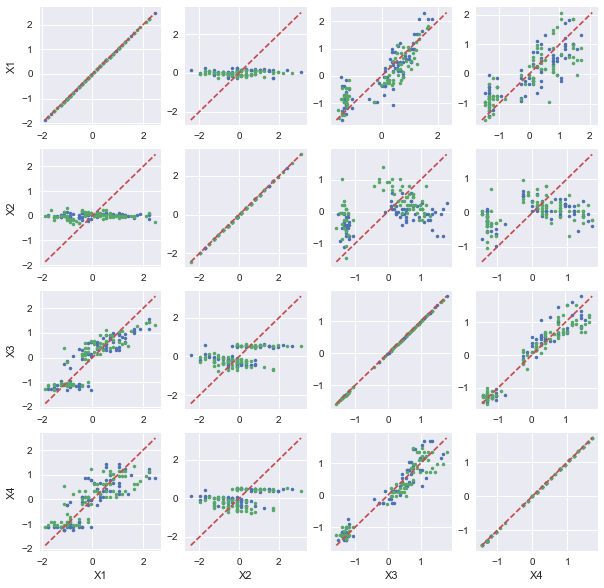

In [ ]:
import matplotlib.pyplot as plt

def pairplot_cross_val(data, model=None, ax=None, **params):
    if ax is None:
        fig, ax = plt.subplots(data.shape[1], data.shape[1], figsize=params.get('figsize', (10,10)))
    if 'figsize' in params:
        del params["figsize"]
    if model is None:
        from sklearn.linear_model import LinearRegression
        model = LinearRegression
    
    df = scale(data)
    cor = numpy.corrcoef(df.T)
    for i in range(cor.shape[0]):
        xi = df[:, i:i+1]
        for j in range(cor.shape[1]):
            xj = df[:, j]
            mem = []
            xi_train, xi_test, xj_train, xj_test = train_test_split(xi, xj, train_size=0.5)
            mod = model(**params)            
            mod.fit(xi_train, xj_train)
            v = mod.predict(xi_test)
            mod = model(**params)            
            mod.fit(xi_test, xj_test)
            v2 = mod.predict(xi_train)
            ax[i,j].plot(xj_test, v, ".")
            ax[i,j].plot(xj_train, v2, ".")
            if j == 0:
                ax[i,j].set_ylabel(data.columns[i])
            if i == data.shape[1]-1:
                ax[i,j].set_xlabel(data.columns[j])
            mi = min(min(xj_test), min(v), min(xj_train), min(v2))
            ma = max(max(xj_test), max(v), max(xj_train), max(v2))
            ax[i,j].plot([mi, ma], [mi, ma], "--")
    return ax
            
ax = pairplot_cross_val(df)
ax

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E93B0C8A58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E93CBD1AC8>]], dtype=object)

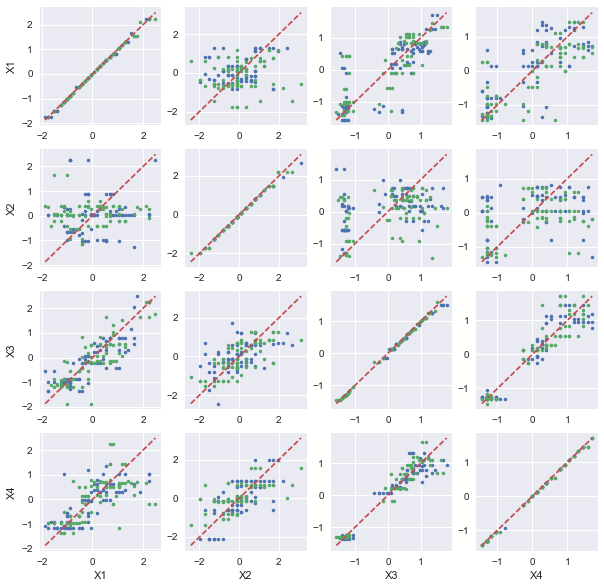

In [ ]:
ax = pairplot_cross_val(df, model=DecisionTreeRegressor)
ax

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E93CCB3D30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E93D3077F0>]], dtype=object)

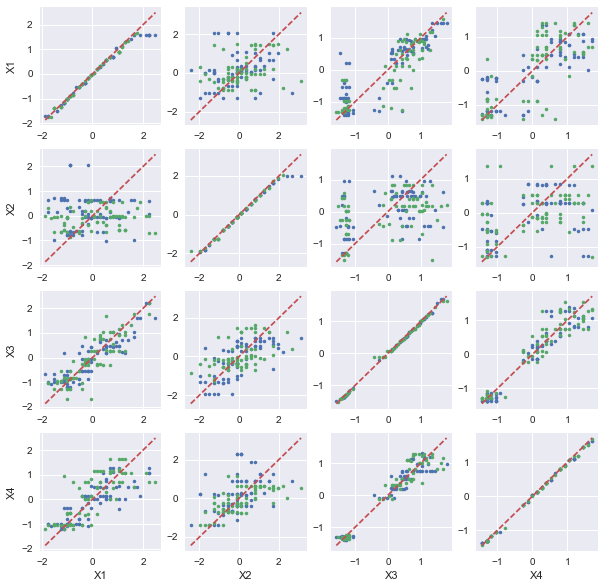

In [ ]:
ax = pairplot_cross_val(df, model=RandomForestRegressor)
ax

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E93D6DAB38>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E93DA356D8>]], dtype=object)

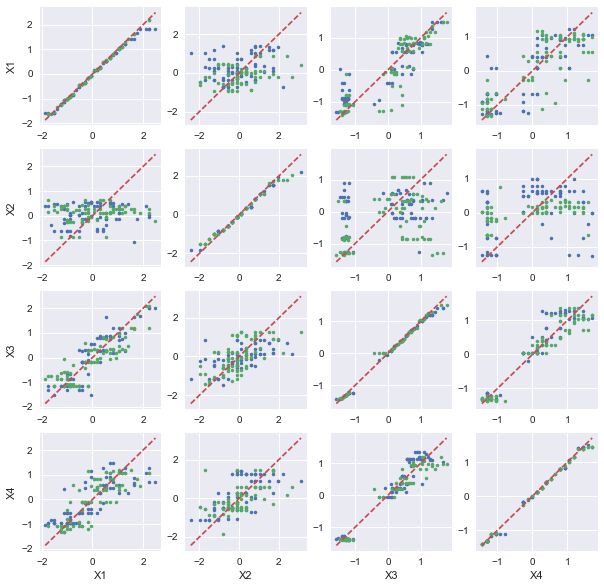

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
ax = pairplot_cross_val(df, model=KNeighborsRegressor)
ax

## Corrélations de variables catégorielles

C'est le problème épineux si on se restreint au linéaire. Cela n'a pas trop de sens d'affecter une valeur à chaque catégorie et la corrélation de deux variables binaires (des modalités) est toujours étrange car il n'y a que deux valeurs possibles.

$$cov(X,Y) = \mathbb{E}\left[(X - \mathbb{E}X)(Y - \mathbb{E}Y)\right] = \mathbb{E}(XY) - \mathbb{E}X\mathbb{E}Y = \mathbb{P}(X=1 \, et \, Y=1) - \mathbb{E}X\mathbb{E}Y$$

Dans le cas de variables binaires générées de modalités de la même variables catégorielles, le premier terme est toujours nul puisque les modalités sont exclusives et la corrélation est toujours négative.

In [ ]:
import random
ex = numpy.zeros((100, 2))
for i in range(0, ex.shape[0]):
    h = random.randint(0, ex.shape[1]-1)
    ex[i, h] = 1
ex[:5]

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.]])

In [ ]:
numpy.corrcoef(ex.T)

array([[ 1., -1.],
       [-1.,  1.]])

In [ ]:
import random
ex = numpy.zeros((100, 3))
for i in range(0, ex.shape[0]):
    h = random.randint(0, ex.shape[1]-1)
    ex[i, h] = 1
ex[:5]
numpy.corrcoef(ex.T)

array([[ 1.        , -0.56860203, -0.39813656],
       [-0.56860203,  1.        , -0.52822293],
       [-0.39813656, -0.52822293,  1.        ]])

Supposons maintenant que nous avons deux variables catégorielles très proches :

* $X_1$ est une couleur rouge, bleu, gris.
* $X_2$ est une nuance rose, orange, cyan, magenta, blanc noir.

In [ ]:
c1 = ["rouge", "bleu", "gris"]
c2 = ["rose" ,"orange" ,"cyan" ,"magenta", "blanc", "noir"]
ind = [random.randint(0, 2) for i in range(0, 100)]
x1 = [c1[i] for i in ind]
x2 = [c2[i*2 + random.randint(0,1)] for i in ind]
df = pandas.DataFrame(dict(X1=x1, X2=x2))
df.head()

,X1,X2
0,rouge,rose
1,gris,noir
2,rouge,orange
3,rouge,orange
4,gris,noir


On peut évidemment transformer en entier.

In [ ]:
dummies = pandas.get_dummies(df)
dummies.head()

,X1_bleu,X1_gris,X1_rouge,X2_blanc,X2_cyan,X2_magenta,X2_noir,X2_orange,X2_rose
0,0,0,1,0,0,0,0,0,1
1,0,1,0,0,0,0,1,0,0
2,0,0,1,0,0,0,0,1,0
3,0,0,1,0,0,0,0,1,0
4,0,1,0,0,0,0,1,0,0


In [ ]:
dummies.corr()

,X1_bleu,X1_gris,X1_rouge,X2_blanc,X2_cyan,X2_magenta,X2_noir,X2_orange,X2_rose
X1_bleu,1.000000,-0.480384,-0.538462,-0.257976,0.638487,0.616748,-0.355395,-0.343801,-0.332095
X1_gris,-0.480384,1.000000,-0.480384,0.537019,-0.306719,-0.296276,0.739814,-0.306719,-0.296276
X1_rouge,-0.538462,-0.480384,1.000000,-0.257976,-0.343801,-0.332095,-0.355395,0.638487,0.616748
X2_blanc,-0.257976,0.537019,-0.257976,1.000000,-0.164714,-0.159106,-0.170269,-0.164714,-0.159106
X2_cyan,0.638487,-0.306719,-0.343801,-0.164714,1.000000,-0.212039,-0.226915,-0.219512,-0.212039
X2_magenta,0.616748,-0.296276,-0.332095,-0.159106,-0.212039,1.000000,-0.219189,-0.212039,-0.204819
X2_noir,-0.355395,0.739814,-0.355395,-0.170269,-0.226915,-0.219189,1.000000,-0.226915,-0.219189
X2_orange,-0.343801,-0.306719,0.638487,-0.164714,-0.219512,-0.212039,-0.226915,1.000000,-0.212039
X2_rose,-0.332095,-0.296276,0.616748,-0.159106,-0.212039,-0.204819,-0.219189,-0.212039,1.000000


Ca ne dit pas grand-chose.

In [ ]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
df["X1e"] = enc.fit_transform(df["X1"])
df["X2e"] = enc.fit_transform(df["X2"])
df.head()

,X1,X2,X1e,X2e
0,rouge,rose,2,5
1,gris,noir,1,3
2,rouge,orange,2,4
3,rouge,orange,2,4
4,gris,noir,1,3


In [ ]:
df.corr()

,X1e,X2e
X1e,1.000000,0.774685
X2e,0.774685,1.000000


Ca ne veut toujours pas dire grand-chose. Et si on change la première colonne en permutant les lables :

In [ ]:
df["X1e"] = df["X1e"].apply(lambda i: (i+1)%3)
df.head()

,X1,X2,X1e,X2e
0,rouge,rose,0,5
1,gris,noir,2,3
2,rouge,orange,0,4
3,rouge,orange,0,4
4,gris,noir,2,3


In [ ]:
df.corr()

,X1e,X2e
X1e,1.000000,-0.665096
X2e,-0.665096,1.000000


La corrélation linéaire sur des variables catégorielles n'a pas de sens. Essayons avec un arbre de décision. C'est le modèle adéquat pour ce type de valeur discrètes :

In [ ]:
cor = correlation_cross_val(df[["X1e", "X2e"]], DecisionTreeRegressor)
cor

,X1e,X2e
X1e,1.0,0.820445
X2e,1.0,1.000000


Et si on permute le premier label :

In [ ]:
df["X1e"] = df["X1e"].apply(lambda i: (i+1)%3)
correlation_cross_val(df[["X1e", "X2e"]], DecisionTreeRegressor)

,X1e,X2e
X1e,1.0,0.791004
X2e,1.0,1.000000


Même résultat qui s'interprète de la sorte :

* La variable *X1e* se déduit de *X2e* (car *cor(X2e, X1e) = 1*).
* La variable *X2e* et fortement lié à *X2e*.

La valeur numérique choisie pour représente la variable catégorielle n'a pas d'impact sur les résultats.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E93DDE1B70>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E93DBCD198>]], dtype=object)

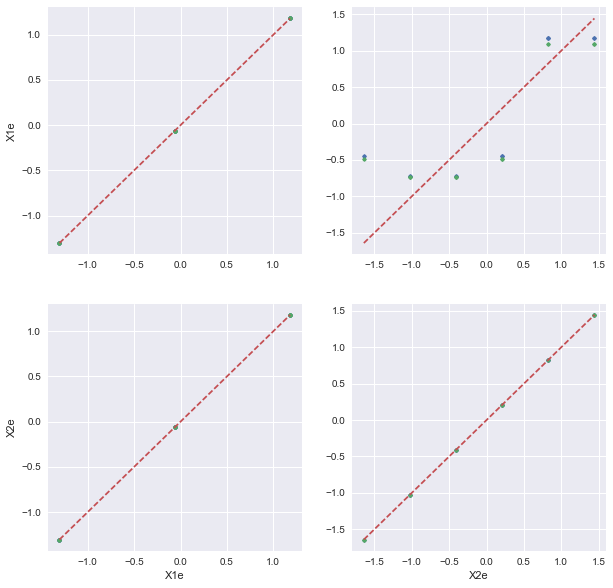

In [ ]:
ax = pairplot_cross_val(df[["X1e", "X2e"]], model=DecisionTreeRegressor)
ax

Et sur un jeu de données plus complet.

In [ ]:
from sklearn.datasets import load_boston
df = load_boston()
df = pandas.DataFrame(df.data, columns=df.feature_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [ ]:
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,1.000000,-0.199458,0.404471,-0.055295,0.417521,-0.219940,0.350784,-0.377904,0.622029,0.579564,0.288250,-0.377365,0.452220
ZN,-0.199458,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,0.404471,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,-0.055295,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,0.417521,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,-0.219940,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,0.350784,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,-0.377904,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,0.622029,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676
TAX,0.579564,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993


On dessine les 5 premières variables. On voit que la variable CHAS est binaire.

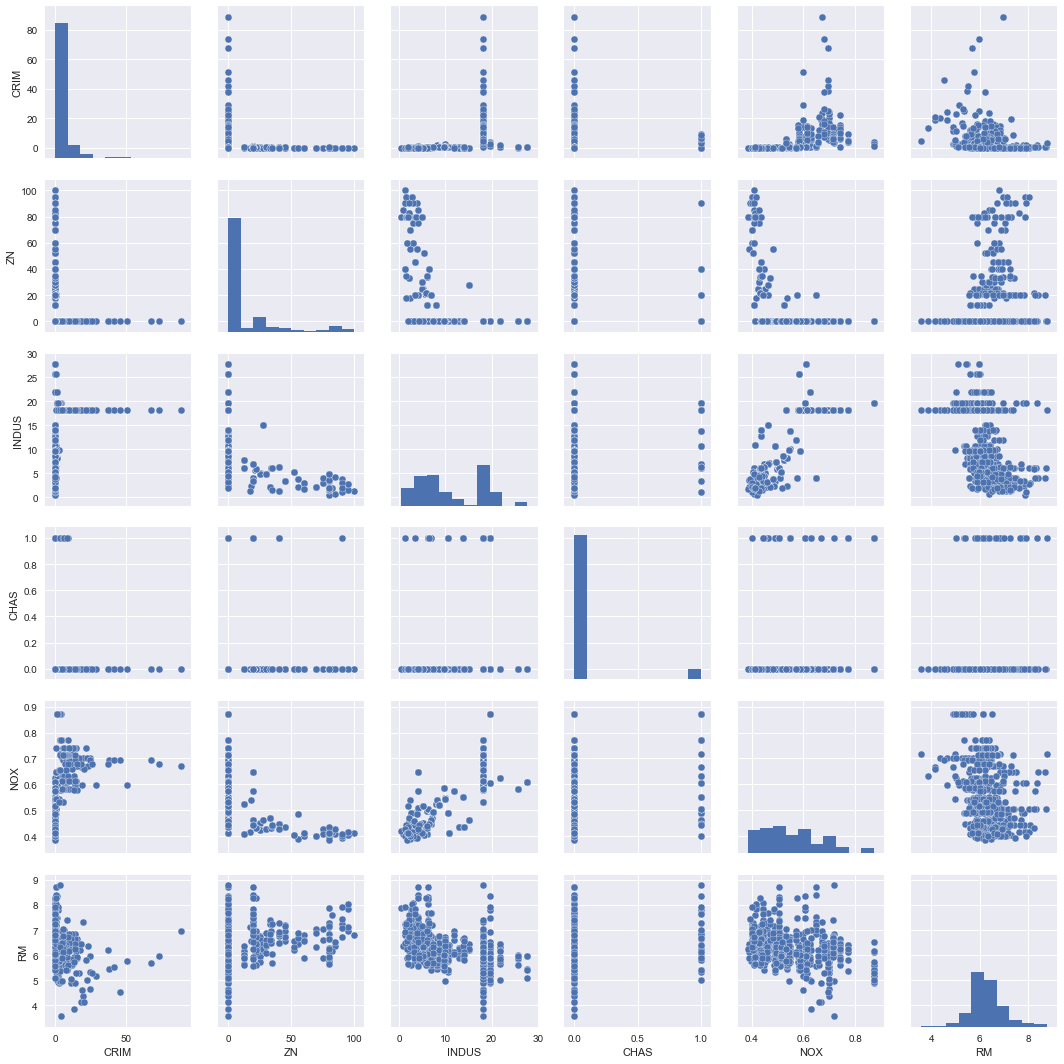

In [ ]:
sns.pairplot(df[df.columns[:6]])

In [ ]:
correlation_cross_val(df, DecisionTreeRegressor)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CRIM,0.980126,0.147788,0.256120,0.000000,0.582833,0.000000,0.029074,0.082306,0.919898,0.771641,0.000000,0.000000,0.048377
ZN,0.255221,0.999685,0.606026,0.329051,0.584690,0.228795,0.550681,0.727205,0.350452,0.396971,0.553860,0.282528,0.371144
INDUS,0.643411,0.859909,0.999963,0.112290,0.899268,0.410792,0.764806,0.917370,0.996819,0.986306,0.921484,0.467578,0.624483
CHAS,0.332084,0.103191,0.056518,1.000000,0.086274,0.144311,0.124583,0.125340,0.133873,0.132164,0.187511,0.129234,0.120171
NOX,0.469877,0.869041,0.969122,0.072649,0.999977,0.305262,0.810078,0.917752,0.996012,0.981622,0.920918,0.617223,0.674619
RM,0.056169,0.000000,0.000000,0.000000,0.000000,0.997902,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077677
AGE,0.104625,0.269147,0.028395,0.000000,0.484970,0.000000,0.999950,0.509697,0.000000,0.000000,0.000000,0.000000,0.041534
DIS,0.064740,0.604207,0.550048,0.000000,0.675384,0.000000,0.603797,0.999733,0.000000,0.000000,0.000000,0.000000,0.049592
RAD,0.622767,0.102810,0.623928,0.134765,0.645417,0.346022,0.496530,0.523616,1.000000,0.916575,0.632807,0.458904,0.480819
TAX,0.552953,0.665689,0.928006,0.093565,0.871699,0.276068,0.712208,0.820918,0.991809,0.999931,0.877740,0.432516,0.566538


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E9446A9F98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E945E7F8D0>]], dtype=object)

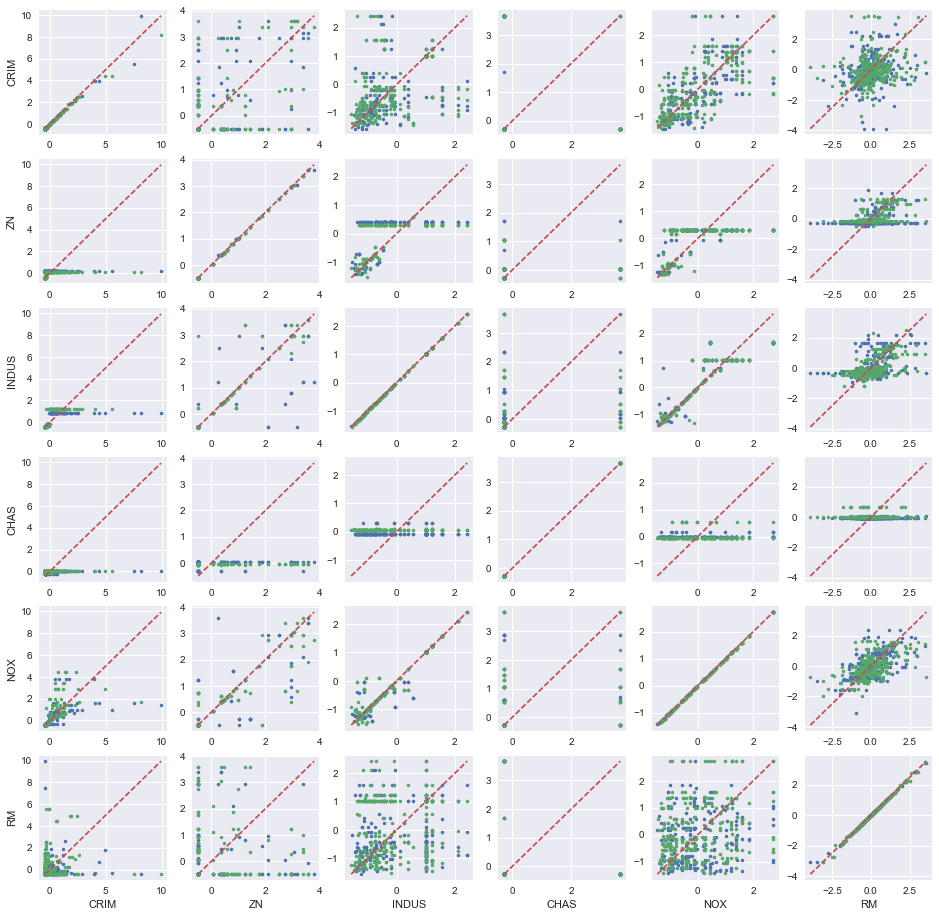

In [ ]:
pairplot_cross_val(df[df.columns[:6]], model=DecisionTreeRegressor, figsize=(16,16))

On regarde en pariculier les variables TAX, RAD, PTRATIO.

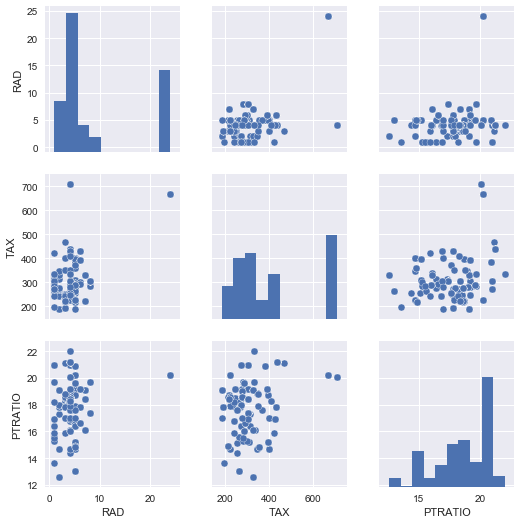

In [ ]:
sns.pairplot(df[["RAD", "TAX", "PTRATIO"]])

In [ ]:
df[["RAD", "TAX", "PTRATIO"]].corr()

,RAD,TAX,PTRATIO
RAD,1.000000,0.910228,0.464741
TAX,0.910228,1.000000,0.460853
PTRATIO,0.464741,0.460853,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E947D42470>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E94842A048>]], dtype=object)

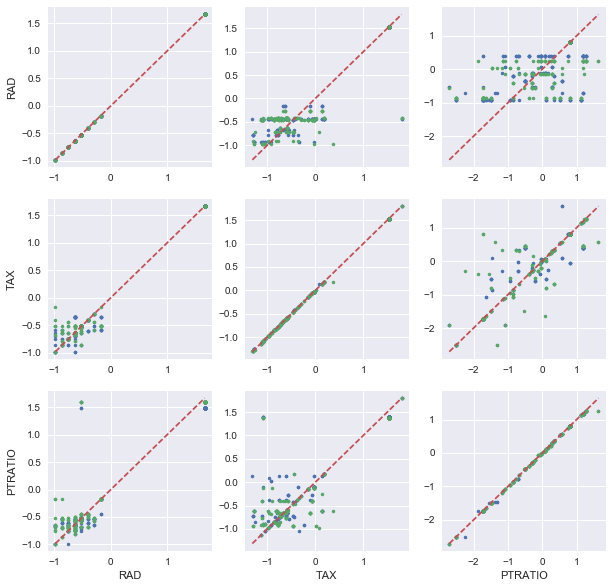

In [ ]:
pairplot_cross_val(df[["RAD", "TAX", "PTRATIO"]], model=DecisionTreeRegressor)

In [ ]:
correlation_cross_val(df[["RAD", "TAX", "PTRATIO"]], DecisionTreeRegressor)

,RAD,TAX,PTRATIO
RAD,1.000000,0.924530,0.593813
TAX,0.991878,0.999820,0.874147
PTRATIO,0.956392,0.918357,0.999748
